In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt

RAW_PATH = Path("manhattan_reviews_final.csv")   # ajusta si está en otra carpeta
CLEAN_PATH = Path("manhattan_reviews_clean.csv")
DICT_PATH = Path("data_dictionary.md")
FIG_RATING = Path("rating_distribution.png")

pd.set_option("display.max_colwidth", 120)

In [3]:
df_raw = pd.read_csv(RAW_PATH, low_memory=False)
print("Filas crudas:", len(df_raw))
print("Columnas:", len(df_raw.columns))
df_raw.head()

Filas crudas: 2070
Columnas: 17


,restaurant_name,neighborhood,cuisine_type,place_url,reviewer_name,rating,review_text,review_text_translated,review_length,published_date,published_timestamp,likes_count,reviewer_total_reviews,is_local_guide,owner_response,review_id,review_url
0,Mission Ceviche,Upper East Side,Peruvian,"https://www.google.com/maps/place/Mission+Ceviche/@40.7722267,-73.9567762,15.25z/data=!4m12!1m2!2m1!1sUpper+East+Sid...",NaN,4.0,"Went on a date with someone who never had Peruvian before, she tells me she really liked it. I Found the food okay, ...",NaN,247,2025-10-07T00:43:31.533Z,4 hours ago,0,24,True,"Hey Ian, \r\n\r\nThank you for visiting us! We're happy to hear your date enjoyed the Peruvian cuisine. We appreciat...",NaN,NaN
1,Mission Ceviche,Upper East Side,Peruvian,"https://www.google.com/maps/place/Mission+Ceviche/@40.7722267,-73.9567762,15.25z/data=!4m12!1m2!2m1!1sUpper+East+Sid...",NaN,5.0,NaN,NaN,0,2025-10-07T00:06:36.680Z,4 hours ago,0,1,False,Hey Jeremy! Thanks a million for the fantastic 5-star review! We’re so happy you had a lovely time with us. Can’t wa...,NaN,NaN
2,Mission Ceviche,Upper East Side,Peruvian,"https://www.google.com/maps/place/Mission+Ceviche/@40.7722267,-73.9567762,15.25z/data=!4m12!1m2!2m1!1sUpper+East+Sid...",NaN,5.0,NaN,NaN,0,2025-10-06T21:19:06.060Z,7 hours ago,0,2,False,Hey Fiorella! Thanks a million for the fantastic 5-star review! We're so happy you enjoyed your time with us. Can’t ...,NaN,NaN
3,Mission Ceviche,Upper East Side,Peruvian,"https://www.google.com/maps/place/Mission+Ceviche/@40.7722267,-73.9567762,15.25z/data=!4m12!1m2!2m1!1sUpper+East+Sid...",NaN,4.0,NaN,NaN,0,2025-10-06T02:03:13.166Z,a day ago,0,1,False,Hey Gemma! Thanks for the 4-star love! We're happy you joined us at our restaurant and hope you had a lovely experie...,NaN,NaN
4,Mission Ceviche,Upper East Side,Peruvian,"https://www.google.com/maps/place/Mission+Ceviche/@40.7722267,-73.9567762,15.25z/data=!4m12!1m2!2m1!1sUpper+East+Sid...",NaN,5.0,Data was great! Will definitely come back,NaN,41,2025-10-06T00:46:13.129Z,a day ago,0,0,False,Hello! Thank you so much for your kind words! We're so happy to hear you enjoyed your time with us. Your support mea...,NaN,NaN


In [4]:
def _make_composite_key(row):
    parts = [
        str(row.get("review_id", "")),
        str(row.get("restaurant_name", "")),
        str(row.get("reviewer_name", "")),
        str(row.get("review_text", "")),
        str(row.get("published_timestamp", "")),
    ]
    s = "||".join(parts)
    return hashlib.md5(s.encode("utf-8", errors="ignore")).hexdigest()

def _ts_to_datetime(series: pd.Series) -> pd.Series:
    ts = pd.to_numeric(series, errors="coerce")
    use_ms = (ts.dropna() > 10**12).mean() > 0.5  # heurística s/ms
    unit = "ms" if use_ms else "s"
    return pd.to_datetime(ts, unit=unit, utc=True, errors="coerce")

def clean_reviews(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()

    # 1) Deduplicación robusta
    key = df.apply(_make_composite_key, axis=1)
    n_dupes = int(key.duplicated().sum())
    df = df.loc[~key.duplicated()].copy()
    print(f"Duplicados removidos: {n_dupes}")

    # 2) Tipos
    for col in ["rating", "likes_count", "reviewer_total_reviews"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if "is_local_guide" in df.columns:
        df["is_local_guide"] = (
            df["is_local_guide"].astype(str).str.strip().str.lower().map({"true": True, "false": False})
        )

    # 3) Fechas
    if "published_timestamp" in df.columns:
        dt = _ts_to_datetime(df["published_timestamp"])
        df["review_datetime_utc"] = dt
        df["review_date"] = df["review_datetime_utc"].dt.date
        df["review_year"] = df["review_datetime_utc"].dt.year
        df["review_month"] = df["review_datetime_utc"].dt.month

    # 4) Texto
    if "review_text" in df.columns:
        df["review_text"] = (
            df["review_text"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
        )

    # 5) Barrio normalizado + canónico (opcional)
    if "neighborhood" in df.columns:
        df["neighborhood_norm"] = df["neighborhood"].astype(str).str.strip()
        CANON_MAP = {
            "UWS": "Upper West Side",
            "UES": "Upper East Side",
            "U.E.S": "Upper East Side",
            "Midtown West": "Midtown",
            "Midtown East": "Midtown",
        }
        df["neighborhood_canon"] = df["neighborhood_norm"].replace(CANON_MAP)

    return df

In [5]:
df = clean_reviews(df_raw)
print("Filas limpias:", len(df))
print("Columnas:", df.columns.tolist())

missing = df.isna().mean().sort_values(ascending=False)
missing.head(15)

Duplicados removidos: 356
Filas limpias: 1714
Columnas: ['restaurant_name', 'neighborhood', 'cuisine_type', 'place_url', 'reviewer_name', 'rating', 'review_text', 'review_text_translated', 'review_length', 'published_date', 'published_timestamp', 'likes_count', 'reviewer_total_reviews', 'is_local_guide', 'owner_response', 'review_id', 'review_url', 'review_datetime_utc', 'review_date', 'review_year', 'review_month', 'neighborhood_norm', 'neighborhood_canon']


review_month              1.000000
review_year               1.000000
review_date               1.000000
review_datetime_utc       1.000000
review_url                1.000000
review_id                 1.000000
reviewer_name             0.988331
review_text_translated    0.929405
owner_response            0.611435
rating                    0.011669
published_timestamp       0.011669
restaurant_name           0.000000
neighborhood_norm         0.000000
likes_count               0.000000
is_local_guide            0.000000
dtype: float64

In [6]:
df.to_csv(CLEAN_PATH, index=False)
CLEAN_PATH, CLEAN_PATH.exists(), len(df)

(WindowsPath('manhattan_reviews_clean.csv'), True, 1714)

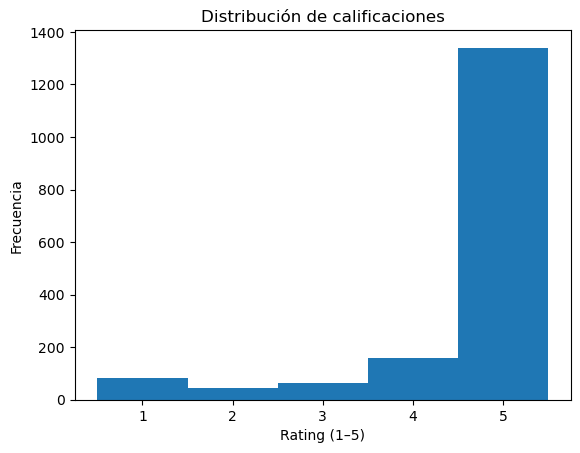

,barrio,cuenta
0,Upper East Side,847
1,Hells Kitchen,847
2,East Harlem,20


,cuisine_type,cuenta
0,Italian,302
1,Thai,269
2,American,250
3,Mexican,186
4,Peruvian,86
5,Greek,75
6,Spanish,71
7,Mediterranean,48
8,Steakhouse,47
9,Latin American,47


In [7]:
# Histograma ratings
if "rating" in df.columns:
    ax = df["rating"].dropna().astype(float).plot(kind="hist",
        bins=[0.5,1.5,2.5,3.5,4.5,5.5], title="Distribución de calificaciones")
    ax.set_xlabel("Rating (1–5)")
    ax.set_ylabel("Frecuencia")
    plt.savefig(FIG_RATING, bbox_inches="tight")
    plt.show()

# Top 10 barrios
if "neighborhood_canon" in df.columns:
    display(df["neighborhood_canon"].value_counts().head(10).rename_axis("barrio").reset_index(name="cuenta"))
elif "neighborhood_norm" in df.columns:
    display(df["neighborhood_norm"].value_counts().head(10).rename_axis("barrio").reset_index(name="cuenta"))

# Top 10 tipos de cocina
if "cuisine_type" in df.columns:
    display(df["cuisine_type"].astype(str).str.strip().value_counts().head(10).rename_axis("cuisine_type").reset_index(name="cuenta"))

In [8]:
def write_data_dictionary(df, path: Path):
    col_desc = {
        "restaurant_name": "Nombre del restaurante.",
        "neighborhood": "Barrio en Manhattan asociado al restaurante.",
        "cuisine_type": "Tipo de cocina (si está disponible).",
        "place_url": "URL del lugar en Google Maps.",
        "reviewer_name": "Nombre del usuario autor de la reseña.",
        "rating": "Calificación numérica de 1 a 5.",
        "review_text": "Texto libre de la reseña.",
        "review_text_translated": "Texto traducido, si se dispone.",
        "review_length": "Longitud del texto de la reseña en caracteres.",
        "published_date": "Fecha de publicación en formato relativo (si se extrajo).",
        "published_timestamp": "Marca de tiempo unix (s/ms).",
        "likes_count": "Cantidad de 'me gusta' de la reseña.",
        "reviewer_total_reviews": "Reseñas totales del autor.",
        "is_local_guide": "Indicador booleano si es Local Guide.",
        "owner_response": "Respuesta del propietario (si existe).",
        "review_id": "ID único de la reseña (si existe).",
        "review_url": "URL directa a la reseña.",
        "review_datetime_utc": "Fecha-hora en UTC derivada del timestamp.",
        "review_date": "Fecha (YYYY-MM-DD) derivada.",
        "review_year": "Año de la reseña (derivado).",
        "review_month": "Mes de la reseña (derivado).",
        "neighborhood_norm": "Barrio normalizado (trim).",
        "neighborhood_canon": "Barrio mapeado a taxonomía canónica.",
    }
    lines = ["# Diccionario de Datos — Manhattan Reviews", "", "Columnas principales y derivadas:", ""]
    for c, d in col_desc.items():
        if c in df.columns:
            example = ""
            try:
                example = str(df[c].dropna().iloc[0]) if df[c].notna().any() else ""
            except Exception:
                example = ""
            lines.append(f"- **{c}**: {d}" + (f"\n  _Ejemplo_: {example}" if example else ""))
    path.write_text("\n".join(lines), encoding="utf-8")
    return path

write_data_dictionary(df, DICT_PATH), DICT_PATH.exists()

(WindowsPath('data_dictionary.md'), True)